In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('D:/Wisdom/workspace_python/research')
sys.path=list(set(sys.path))

import keras
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout)
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

from model.keras_models import create_dense_layers, inst_layers
from module_DTI.utils import plot_mse_mae_history, plot_roc_curve, plot_epoch_acc_loss

from sklearn.datasets import load_iris

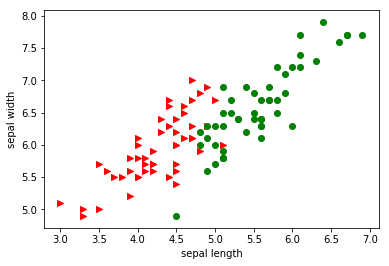

In [8]:
for t in range(3):
    if t == 0:
        c='r'
        marker='>'
    elif t == 1:
        c='g'
        marker='o'
    plt.scatter(features[target == t, 2],   # sepal length
                features[target == t, 0],   # sepal width
                marker = marker,
                c = c)
    plt.xlabel("sepal length")
    plt.ylabel("sepal width")

In [3]:
#data = load_iris()
# features=data.data[:]
# target=data.target[:]
file='https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
data=pd.read_csv(file,names=['pregnancies','glucose','diastolic','triceps','insulin','bmi',
                            'dpf','age','diabetes'])
features=data.drop(columns=['diabetes'])
target=data['diabetes']

In [4]:

x=features
x=(x-np.min(x,axis=0))/(np.max(x,axis=0)-np.min(x,axis=0))
y=target
y=to_categorical(target)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=1)


In [5]:
class MultiLayerPerceptron(Model):
    def __init__(self, inputs, **kwargs):
        layers=[
            create_dense_layers(stage='mlp_1', units=256, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='mlp_2', units=100, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='mlp_last', units=2, activation='softmax', dropout=0.0, batch_normalization='off'),
        ]
        outputs = inst_layers(layers, inputs)
        super(MultiLayerPerceptron, self).__init__(inputs, outputs, **kwargs)

class Encoder(Model):
    def __init__(self, inputs, encoding_dim, **kwargs):
        layers = [
            create_dense_layers(stage='enc_1', units=512, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='enc_2', units=128, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='enc_last', units=encoding_dim, activation='linear', dropout=0.0, batch_normalization='off'),
        ]
        outputs = inst_layers(layers, inputs)
        super(Encoder, self).__init__(inputs, outputs, **kwargs)


class Decoder(Model):
    def __init__(self, inputs, decoding_dim, **kwargs):
        layers = [
            create_dense_layers(stage='dec_1', units=128, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='dec_2', units=512, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='dec_last', units=decoding_dim, activation='linear', dropout=0.0, batch_normalization='off'),
        ]
        outputs = inst_layers(layers, inputs)
        super(Decoder, self).__init__(inputs, outputs, **kwargs)


class AutoEncoder(Model):
    def __init__(self, inputs, latent_dim, **kwargs):
        x=inputs
        encoder=Encoder(inputs=inputs,encoding_dim=latent_dim, name='encoder')

        z=encoder(x)
        z_inputs=Input(shape=(latent_dim,),name='decoder_input')
        decoder=Decoder(inputs=z_inputs,decoding_dim=int(inputs.shape[1]), name='decoder')

        outputs =decoder(z)
        super(AutoEncoder,self).__init__(inputs,outputs, **kwargs)
        self.encoder=encoder
        self.decoder=decoder
        


In [6]:
inputs=Input(shape=(8,))
C=AutoEncoder(inputs,10)
# C.summary()
C.compile(loss='mse',optimizer=Adam(), metrics=['mse','mae'])
h=C.fit(x_train,x_train,epochs=100,validation_data=(x_test,x_test))

Train on 691 samples, validate on 77 samples
Epoch 1/100
691/691 [==============================] - 3s 5ms/step - loss: 0.9558 - mean_squared_error: 0.9558 - mean_absolute_error: 0.7378 - val_loss: 0.2138 - val_mean_squared_error: 0.2138 - val_mean_absolute_error: 0.3552
Epoch 2/100
691/691 [==============================] - 0s 316us/step - loss: 0.5989 - mean_squared_error: 0.5989 - mean_absolute_error: 0.5889 - val_loss: 0.1108 - val_mean_squared_error: 0.1108 - val_mean_absolute_error: 0.2500
Epoch 3/100
691/691 [==============================] - 0s 475us/step - loss: 0.4706 - mean_squared_error: 0.4706 - mean_absolute_error: 0.5219 - val_loss: 0.1023 - val_mean_squared_error: 0.1023 - val_mean_absolute_error: 0.2360
Epoch 4/100
691/691 [==============================] - 0s 543us/step - loss: 0.4275 - mean_squared_error: 0.4275 - mean_absolute_error: 0.4875 - val_loss: 0.0703 - val_mean_squared_error: 0.0703 - val_mean_absolute_error: 0.2059
Epoch 5/100
691/691 [====================

Epoch 72/100
691/691 [==============================] - 0s 613us/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0761 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0651
Epoch 73/100
691/691 [==============================] - 0s 501us/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0778 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0581
Epoch 74/100
691/691 [==============================] - 0s 361us/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0754 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0621
Epoch 75/100
691/691 [==============================] - 0s 404us/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0755 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0581
Epoch 76/100
691/691 [==============================] - 0s 560us/step - loss: 0.

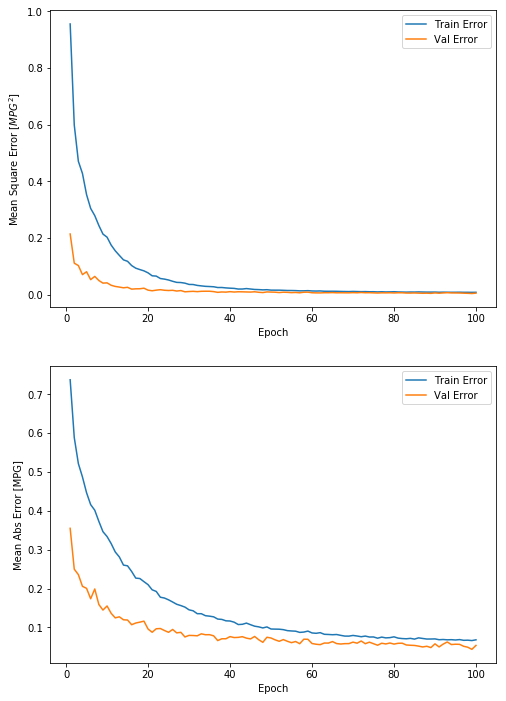

In [7]:
plot_mse_history(h.history)

In [12]:
ae_x_train=C.encoder.predict(x_train)
ae_x_test=C.encoder.predict(x_test)

In [13]:
class MultiLayerPerceptron(Model):
    def __init__(self, inputs, **kwargs):
        layers=[
            create_dense_layers(stage='mlp_1', units=256, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='mlp_2', units=100, activation='relu', dropout=0.3, batch_normalization='on'),
            create_dense_layers(stage='mlp_last', units=2, activation='softmax', dropout=0.0, batch_normalization='off'),
        ]
        outputs = inst_layers(layers, inputs)
        super(MultiLayerPerceptron, self).__init__(inputs, outputs, **kwargs)


In [15]:
inputs_mlp=Input(shape=(8,))
inputs_ae=Input(shape=(10,))
C_mlp=MultiLayerPerceptron(inputs_mlp)
C_ae=MultiLayerPerceptron(inputs_ae)
C_mlp.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])
h_mlp=C_mlp.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))
C_ae.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=['accuracy'])
h_ae=C_ae.fit(ae_x_train,y_train,epochs=100,validation_data=(ae_x_test,y_test))

Train on 691 samples, validate on 77 samples
Epoch 1/100
691/691 [==============================] - 2s 3ms/step - loss: 0.7644 - acc: 0.6122 - val_loss: 0.5820 - val_acc: 0.7662
Epoch 2/100
691/691 [==============================] - 0s 195us/step - loss: 0.5747 - acc: 0.7453 - val_loss: 0.4604 - val_acc: 0.7922
Epoch 3/100
691/691 [==============================] - 0s 242us/step - loss: 0.5427 - acc: 0.7511 - val_loss: 0.4410 - val_acc: 0.7662
Epoch 4/100
691/691 [==============================] - 0s 212us/step - loss: 0.5065 - acc: 0.7656 - val_loss: 0.4345 - val_acc: 0.8182
Epoch 5/100
691/691 [==============================] - 0s 247us/step - loss: 0.5103 - acc: 0.7540 - val_loss: 0.4467 - val_acc: 0.7792
Epoch 6/100
691/691 [==============================] - 0s 316us/step - loss: 0.4882 - acc: 0.7583 - val_loss: 0.4528 - val_acc: 0.7403
Epoch 7/100
691/691 [==============================] - 0s 277us/step - loss: 0.4850 - acc: 0.7525 - val_loss: 0.4359 - val_acc: 0.7273
Epoch 8/100


Epoch 61/100
691/691 [==============================] - 0s 267us/step - loss: 0.3956 - acc: 0.8205 - val_loss: 0.4188 - val_acc: 0.7792
Epoch 62/100
691/691 [==============================] - 0s 206us/step - loss: 0.4029 - acc: 0.8278 - val_loss: 0.4259 - val_acc: 0.8182
Epoch 63/100
691/691 [==============================] - 0s 176us/step - loss: 0.3942 - acc: 0.8177 - val_loss: 0.4270 - val_acc: 0.8052
Epoch 64/100
691/691 [==============================] - 0s 176us/step - loss: 0.3823 - acc: 0.8292 - val_loss: 0.4246 - val_acc: 0.7922
Epoch 65/100
691/691 [==============================] - 0s 180us/step - loss: 0.3837 - acc: 0.8205 - val_loss: 0.4232 - val_acc: 0.7922
Epoch 66/100
691/691 [==============================] - 0s 154us/step - loss: 0.4005 - acc: 0.8119 - val_loss: 0.4294 - val_acc: 0.7662
Epoch 67/100
691/691 [==============================] - 0s 153us/step - loss: 0.4168 - acc: 0.8119 - val_loss: 0.4505 - val_acc: 0.7922
Epoch 68/100
691/691 [==========================

Epoch 21/100
691/691 [==============================] - 0s 188us/step - loss: 0.4581 - acc: 0.7959 - val_loss: 0.4112 - val_acc: 0.7532
Epoch 22/100
691/691 [==============================] - 0s 173us/step - loss: 0.4495 - acc: 0.7757 - val_loss: 0.4122 - val_acc: 0.7922
Epoch 23/100
691/691 [==============================] - 0s 159us/step - loss: 0.4598 - acc: 0.7757 - val_loss: 0.4080 - val_acc: 0.7792
Epoch 24/100
691/691 [==============================] - 0s 172us/step - loss: 0.4605 - acc: 0.7829 - val_loss: 0.4170 - val_acc: 0.7792
Epoch 25/100
691/691 [==============================] - 0s 218us/step - loss: 0.4681 - acc: 0.7685 - val_loss: 0.4085 - val_acc: 0.7922
Epoch 26/100
691/691 [==============================] - 0s 201us/step - loss: 0.4377 - acc: 0.7887 - val_loss: 0.4150 - val_acc: 0.7792
Epoch 27/100
691/691 [==============================] - 0s 209us/step - loss: 0.4554 - acc: 0.7858 - val_loss: 0.4225 - val_acc: 0.7792
Epoch 28/100
691/691 [==========================

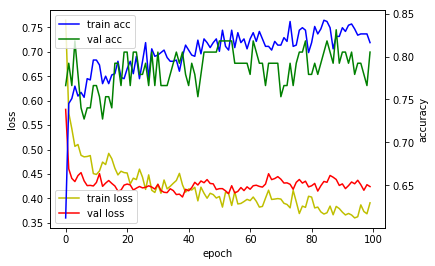

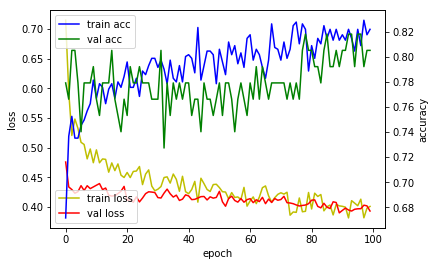

In [17]:
plot_epoch_acc_loss(h_mlp)
plot_epoch_acc_loss(h_ae)

In [22]:
print(C_mlp.evaluate(x_test,y_test))
print(C_ae.evaluate(ae_x_test,y_test))

77/77 [==============================] - 0s 285us/step
[0.42422113635323266, 0.8051948090652367]
77/77 [==============================] - 0s 790us/step
[0.3931181515966143, 0.805194809839323]
